## 可視化

さて可視化する.

In [1]:
import numpy as np
import scipy as sp
from scipy import stats
from scipy import special

import pandas as pd
pd.set_option('display.width', 200)
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import os
import subprocess
import warnings
warnings.filterwarnings('ignore')

### テストデータ

適当なテストデータ. 2つの正規分布の3:7の混合です. データ数は100. ちょっとくっついている.

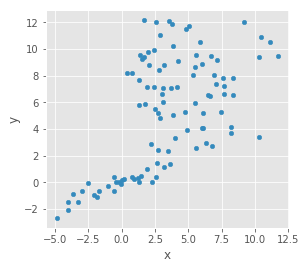

In [2]:
np.random.seed(0)
mean0 = np.array([0, 0])
cov0 = np.array([[5,2],[2,1]])
mean1 = np.array([5, 7])
cov1 = np.array([[8,0],[0,7]])
N = 100
K = 2
a = 0.7
X = pd.DataFrame(
    np.r_[
        sp.random.multivariate_normal(mean0, cov0, int(N*(1-a))),
        sp.random.multivariate_normal(mean1, cov1, int(N*a))
    ],
    columns=['x', 'y']
)
X.plot(kind='scatter', x='x', y='y').set_aspect('equal')
plt.savefig('1.png', bbox_inches='tight', pad_inches=0)

### 事前分布

適当な事前分布.

In [3]:
x = X.values.T
D = 2

# 事前分布
b0 = 1
m0 = np.zeros((D, 1))
W0 = np.diag([0.01, 0.01])
nu0 = 1.1
a0 = 1

### パラメータ変数と推定関数

パラメータ変数を定義する関数. 初期値も与える. mkの初期値が乱数なのは, これが2分布で同じ値だと事後分布も同じ分布になってしまうため. 別にWkの初期値を乱数で与えてもいいはず.

In [4]:
def init():
    global mk, Wk, nuk, bk, ak, r, rho
    mk = np.random.rand(K, D, 1)
    Wk = np.array([np.diag([0.01, 0.01]) for _ in np.arange(K)])
    nuk = np.repeat(1.1, K)
    bk = np.ones(K)
    ak = np.ones(K)

    r = np.zeros((N, K))
    rho = np.zeros((N, K))
# init()

$r_{nk}$ を更新する関数.

In [5]:
# mk, Wk, bk, nukの更新
def step1():
    for k in np.arange(K):
        ln_Lambda_tilde_k = ( \
            np.sum(sp.special.digamma((nuk[k]+1-i)/2) for i in np.arange(1, D+1)) \
            + D * np.log(2) \
            + np.log(np.linalg.det(Wk[k])) \
        )
        ln_pi_tilde_k = sp.special.digamma(ak[k]) - sp.special.digamma(ak.sum())
        for n in np.arange(N):
            rho[n, k] = \
                1/2*ln_Lambda_tilde_k \
                - D / 2 * np.log(2*np.pi) \
                - 1/2 * nuk[k] * ((x[:, n:n+1] - mk[k]).T@Wk[k]@(x[:, n:n+1] - mk[k]))[0, 0] \
                - 1/2 * D / bk[k] \
                + ln_pi_tilde_k
            rho[n, k] = np.exp(rho[n, k])
    for n in np.arange(N):
        r[n, :] = rho[n, :] / rho[n, :].sum()

# init()
# step1()

$\boldsymbol \alpha_{k}, \mathbf m_{k}, \mathbf W_{k}, \boldsymbol \beta_{k}, \boldsymbol \nu_{k}$ を更新する関数.

In [6]:
# rの更新
def step2():
    Nk = r.sum(axis=0)
    for k in range(K):
        xbark = x@r[:, k:k+1] / Nk[k]
        Sk = 0
        for n in range(N):
            Sk += r[n, k] * (x[:,n:n+1] - xbark)@(x[:,n:n+1] - xbark).T
        Sk /= Nk[k]

        mk[k] = (Nk[k] * xbark + b0 * m0) / (Nk[k] + b0)
        bk[k] = Nk[k] + b0
        Wkinv = np.linalg.inv(W0) + (Nk[k]*b0)/(Nk[k]+b0) * (xbark - m0)@(xbark - m0).T + Nk[k] * Sk
        Wk[k] = np.linalg.inv(Wkinv)
        nuk[k] = Nk[k] + nu0

        ak[k] = Nk[k] + a0

# init()
# step1()
# step2()

### 推定の実施

200回の繰り返しを実施. 適当にPythonで書いてもとても速い. 同じ問題をstanで解いても数10秒はかかると思う.

In [7]:
%%time
init()
ak_history = pd.DataFrame(
    [[step1(), step2(), ak.copy()][-1] for _ in range(200)],
    columns=[f'Gr.{x}' for x in range(K)]
)

CPU times: user 893 ms, sys: 342 ms, total: 1.24 s
Wall time: 653 ms


データ数の分類のそれぞれの個数と平均. 真の分布と大体同じ.

In [8]:
print(f"混合比: {ak / ak.sum()}")
[print(f"クラスタ{i}の平均: {mk[i][0][0]:3.5f}, {mk[i][1][0]:3.5f}") for i in range(K)];

混合比: [0.67219215 0.32780785]
クラスタ0の平均: 4.80261, 7.41357
クラスタ1の平均: 0.23764, 0.36730


ステップが進行するにつれて推定がよくなってくれることを確認するために, 混合比の履歴を可視化. 収束している感は出ている.

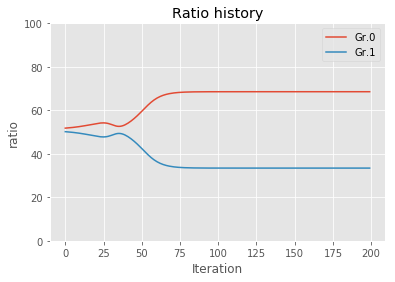

In [9]:
ax = ak_history.plot(title='Ratio history')
ax.set_ylim(0, 100)
ax.set_xlabel('Iteration')
ax.set_ylabel('ratio')
plt.savefig('2.png', bbox_inches='tight', pad_inches=0);

事後分布のZを可視化. 綺麗に分類できていることがわかる.

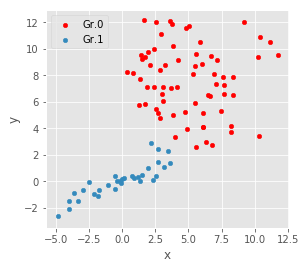

In [10]:
P = X.copy()
P['group'] = r.argmax(axis=1)
ax = P[P['group']==0].plot(kind='scatter', x='x', y='y', c='r', label='Gr.0')
for k in range(1, K):
    P[P['group']==k].plot(kind='scatter', x='x', y='y', label=f'Gr.{k}', c=colors[k], ax=ax).set_aspect('equal')
plt.savefig('3.png', bbox_inches='tight', pad_inches=0)

事後予測分布を可視化.

In [11]:
def t_pdf(x, m, Lambda, df):
    D = len(m)
    m = m.reshape(D, 1)
    x = x.T

    return np.diag(
        sp.special.gamma(D/2. + df/2.) /
        sp.special.gamma(df/2.) *
        np.power(np.linalg.det(Lambda), 1/2.) / 
        np.power(np.pi * df, D/2.) *
        np.power(1 + (x-m).T@Lambda@(x-m)/df, -(D+df)/2.)
    )

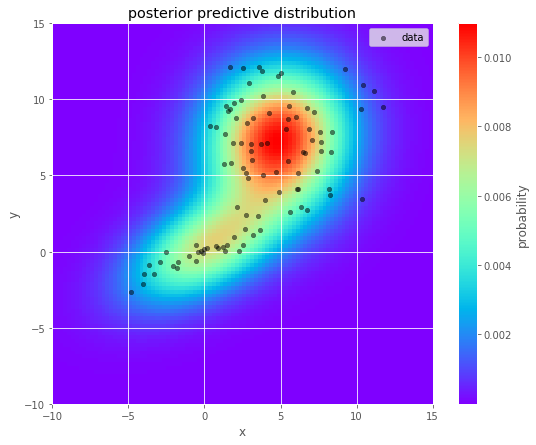

In [12]:
fig, ax = plt.subplots(ncols=1, figsize=(9, 7))

ax.set_aspect('equal')
ax.set_title('posterior predictive distribution')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')

delta = 0.25
xrange = np.array([-10, 15])
yrange = np.array([-10, 15])
gx = np.arange(*(xrange + delta/2), delta)
gy = np.arange(*(yrange + delta/2), delta)
gxx, gyy = np.meshgrid(gx, gy)
gxgy = np.c_[gxx.ravel(), gyy.ravel()]

# parameters of posterior predictive distribution
zz = ak[0]/ak.sum() * t_pdf(
    gxgy,
    mk[0],
    bk[0] * (nuk[0] + 1 - D) * Wk[0] / (1 + bk[0]),
    (nuk[0] + 1 - D)
) + ak[1]/ak.sum() * t_pdf(
    gxgy,
    mk[1],
    bk[1] * (nuk[1] + 1 - D) * Wk[1] / (1 + bk[1]),
    (nuk[1] + 1 - D)
) 

im = ax.imshow(
    zz.reshape(len(gx), len(gy)), 
    interpolation='none', 
    origin='lower',
    extent=list(xrange) + list(yrange),
    cmap=matplotlib.cm.rainbow
)
fig.colorbar(im, ax=ax).set_label('probability')
X.plot(kind='scatter', x='x', y='y', c='black', ax=ax, label='data', alpha=0.5)
plt.savefig('4.png', bbox_inches='tight', pad_inches=0);

事後予測分布を描くのも簡単である.
おわり.

## その他

Variational inferenceは速い上に事後分布が共役事前分布と同じ形になるのでとても便利である. ギブスサンプリングだとこうはいかない.

例えば, 予測分布が簡単に計算できるので, データD次元+データの分類N次元の教師データを使って混合正規分布モデルなりで事後分布を得れば, そこから任意データに対して分類N次元の予測分布を簡単に計算できる. 文字認識とかできそうである. 一度はやってみたい文字認識.

そういえば事後分布が事前分布と同じ形ということは, 逐次的にデータが増える環境において, 事後分布を次の事前分布にして逐次学習とかできそうである. 一度はやってみたいオンライン機械学習.

比較用に同じモデル, 事前分布でStanでサンプリングしたのだが, W0がゆるすぎるのか, 片方の分布の分散共分散がぶっとんでしまう. 
W0が[[0.1, 0], [0, 0.1]]だとよく推定できた. ただしこの場合でも, 混合分布の推定は分布の添字が入れ替わるので出来合いのrhatのスコアが悪く気持ち悪い. うまい方法はないだろうか. 

初期値といえばvariational inferenceには(当然?)初期値依存性がある, ハズである. 今回の例では2分布のパラメータの初期値が同じだと事後分布も同じになる. 混合比は0.5となる. 初期値に乱数をふって複数回の推定が必要なのではないか? その場合はどの初期値での事後分布がいいのか比較と取捨選択が必要になる. どうするのだろう. この辺がわからないのはそもそもvariational inferenceの仕組みを理解していないからだ.

### おまけ

こんなデータ.

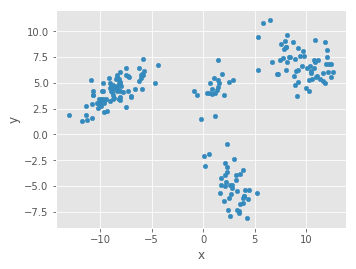

In [13]:
def mean():
    return np.random.uniform(-10,10,2)

def cov():
    cov = np.random.uniform(-4,4,4)
    cov[0] = np.abs(cov[0])
    cov[3] = np.abs(cov[3])
    cov[2] = cov[1]
    return cov.reshape((2,2))

np.random.seed(0)
N = 200
K = 4
pi = [0.1, 0.2, 0.3, 0.4]
X = pd.DataFrame(
    np.vstack([sp.random.multivariate_normal(mean(), cov(), int(N*pi[i])) for i in range(K)]),
    columns=['x', 'y'])

X.plot(kind='scatter', x='x', y='y').set_aspect('equal')
plt.savefig('5.png', bbox_inches='tight', pad_inches=0)

In [14]:
x = X.values.T

# 事前分布を変更
W0 = np.diag([1, 1])

In [15]:
%%time
init()
ak_history = pd.DataFrame(
    [[step1(), step2(), ak.copy()][-1] for _ in range(200)],
    columns=[f'Gr.{x}' for x in range(K)]
)
print(f"混合比: {ak / ak.sum()}")
[print(f"クラスタ{i}の平均: {mk[i][0][0]:3.5f}, {mk[i][1][0]:3.5f}") for i in range(K)];

混合比: [0.3970738  0.29961274 0.2011257  0.10218777]
クラスタ0の平均: -8.48932, 4.14327
クラスタ1の平均: 9.38159, 6.79947
クラスタ2の平均: 2.76510, -4.92961
クラスタ3の平均: 1.01452, 4.21432
CPU times: user 3.37 s, sys: 1.11 s, total: 4.48 s
Wall time: 2.26 s


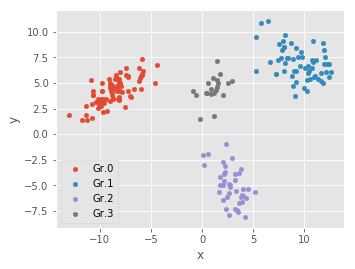

In [16]:
P = X.copy()
ax = plt.subplot()
P['group'] = r.argmax(axis=1)
for k in range(K):
    if P[P['group']==k].empty: continue
    P[P['group']==k].plot(kind='scatter', x='x', y='y', label=f'Gr.{k}', c=colors[k], ax=ax).set_aspect('equal')
plt.savefig('6.png', bbox_inches='tight', pad_inches=0)

ほんと簡単.